<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Convolutional Neural Network with Small Images</h1> 



<h3>Objective for this Notebook<h3>    
<h5> 1. Learn how to use a Convolutional Neural Network to classify handwritten digits from the MNIST database</h5>
<h5> 2. Learn hot to reshape the images to make them faster to process </h5>     



<h2>Table of Contents</h2>
<p>In this lab, we will use a Convolutional Neural Network to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process </p>

<ul>
<li><a href="#Makeup_Data">Get the Data</a></li>
<li><a href="#CNN">Build a Convolutional Neural Network Class</a></li>
<li><a href="#Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong> 14 min to train model </p>

<hr>


<h2>Preparation</h2>


In [1]:


# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !mamba install -y torchvision

!pip install torchvision torch 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

Define the function <code>plot_channels</code> to plot out the kernel parameters of  each channel 


In [2]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define the function <code>plot_parameters</code> to plot out the kernel parameters of each channel with Multiple outputs . 


In [3]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function <code>plot_activation</code> to plot out the activations of the Convolutional layers  


In [4]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

Define the function <code>show_data</code> to plot out data samples as images.


In [5]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<a id="Makeup_Data"></a>
<h2>Get the Data</h2>


We create a transform to resize the image and convert it to a tensor.


In [6]:


IMAGE_SIZE = 16


composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.


In [7]:

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

100%|██████████| 9.91M/9.91M [00:22<00:00, 450kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 104kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.09MB/s]


Load the testing dataset by setting the parameters train  <code>False</code>.


In [8]:
# Make the validating 

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

We can see the data type is long.


In [9]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">


Print out the fourth label 


In [10]:
# The label for the fourth data element

train_dataset[3][1]

1

Plot the fourth sample 


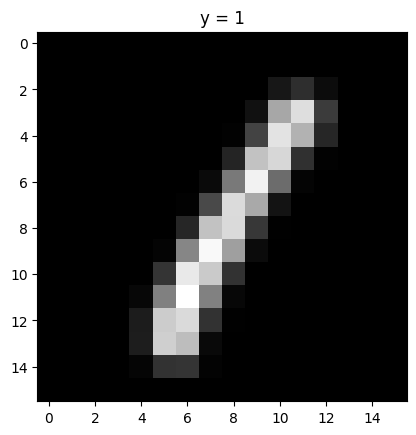

In [11]:
# The image for the fourth data element
show_data(train_dataset[3])


The fourth sample is a "1".


<!--Empty Space for separating topics-->


<a id="CNN"></a>
<h2>Build a Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.


In [12]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

<a id="Train"></a>
<h2>Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2>


There are 16 output channels for the first layer, and 32 output channels for the second layer 


In [13]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.


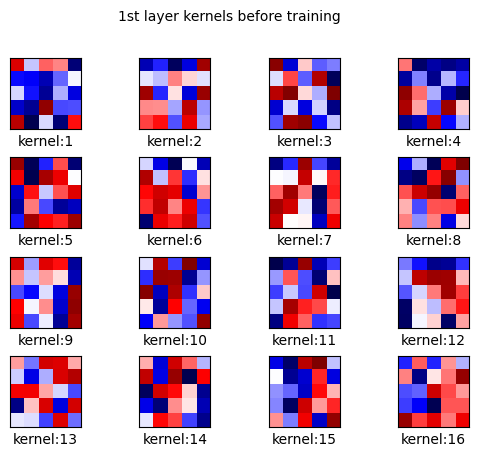

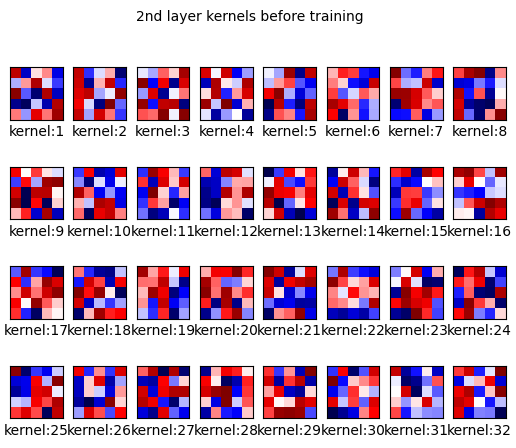

In [14]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Define the loss function, the optimizer and the dataset loader 


In [15]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**


In [16]:
# Train the model

n_epochs=3
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

<!--Empty Space for separating topics-->


<a id="Result"></a>
<h2> Analyze Results</h2> 


Plot the loss and accuracy on the validation data:


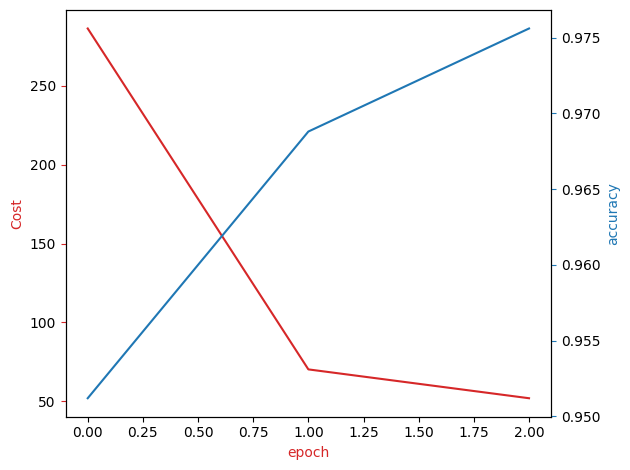

In [17]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers 


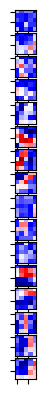

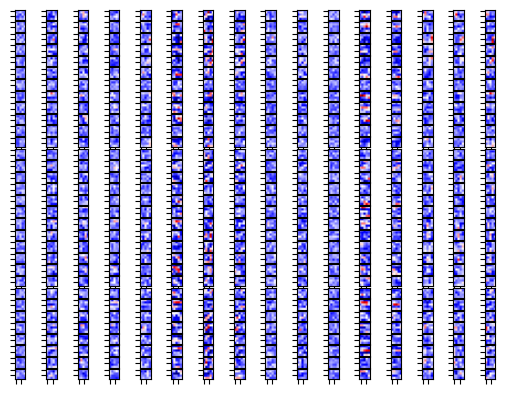

In [18]:
# Plot the channels

plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample 


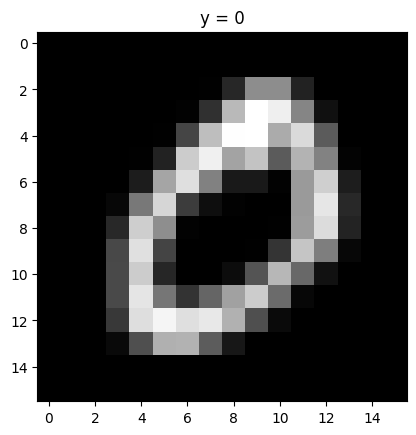

In [19]:
# Show the second image

show_data(train_dataset[1])

Determine the activations 


In [20]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plot out the first set of activations 


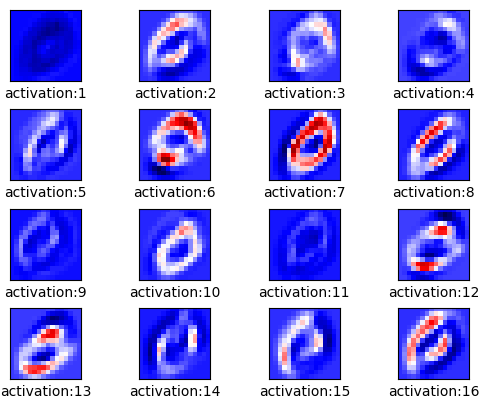

In [21]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function 


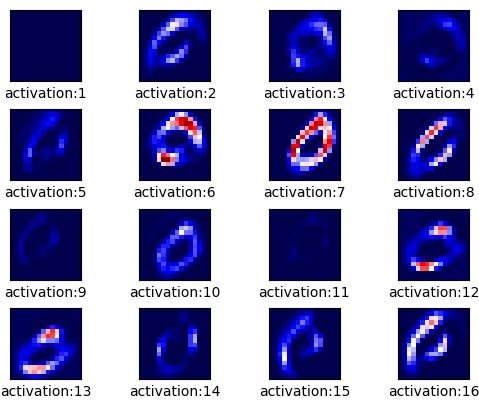

In [22]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

The image below is the result of the activation map after the second output layer.


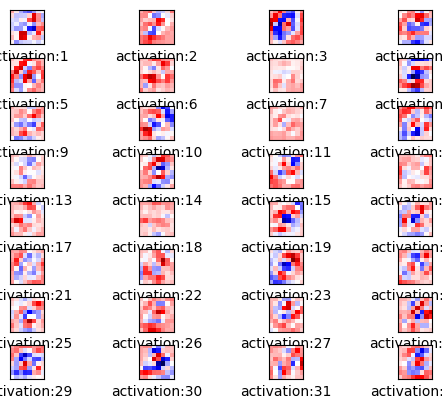

In [23]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

The image below is the result of the activation map after applying the second relu  


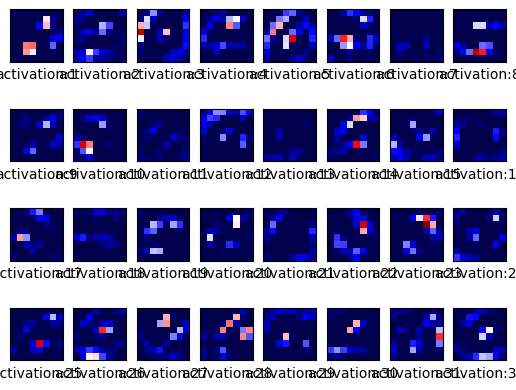

In [24]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

We can  see the result for the third sample 


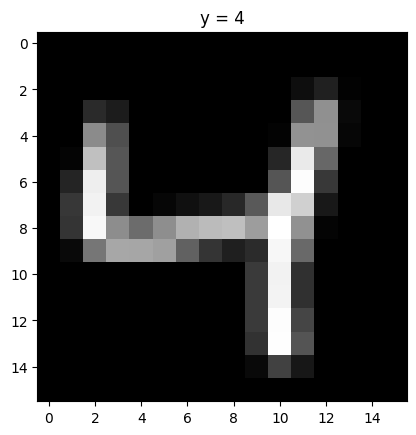

In [25]:
# Show the third image

show_data(train_dataset[2])

In [26]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

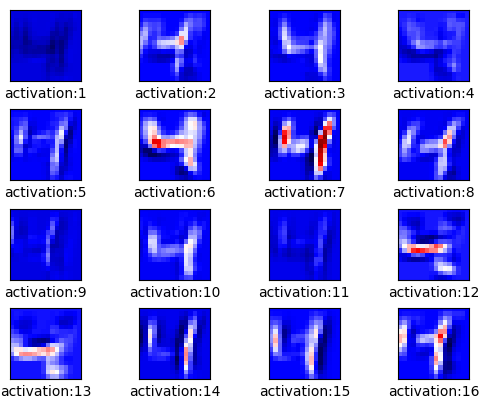

In [27]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

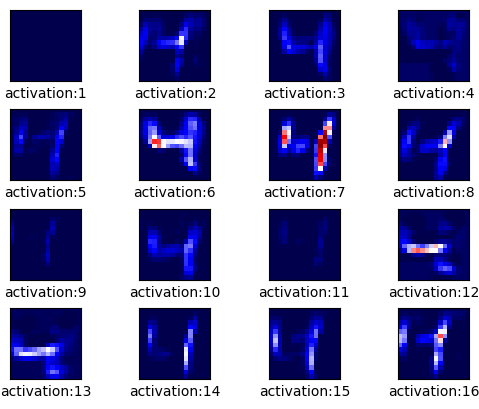

In [28]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

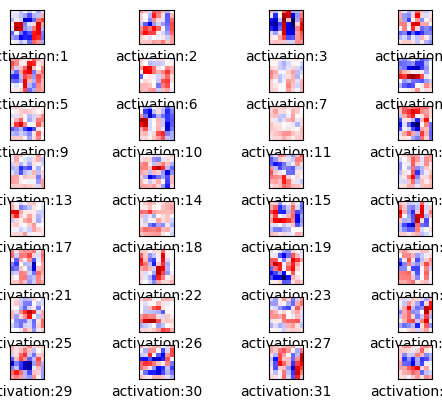

In [29]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

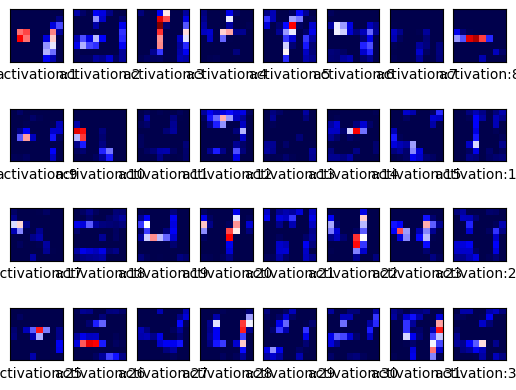

In [30]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

Plot the first five mis-classified samples:


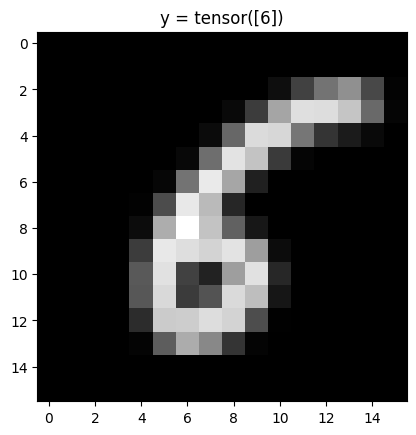

yhat:  tensor([5])


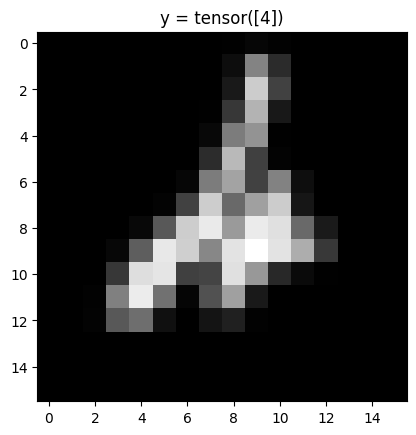

yhat:  tensor([2])


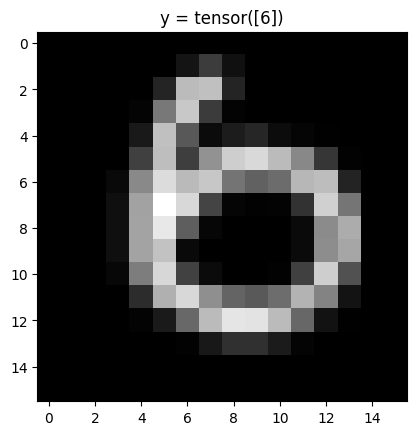

yhat:  tensor([0])


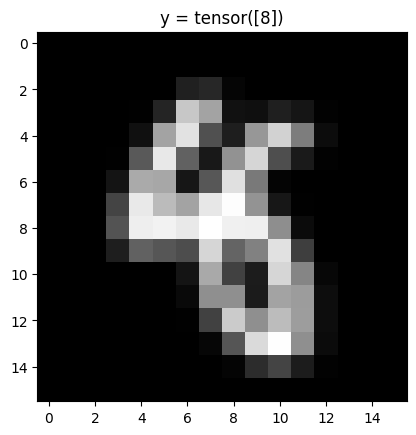

yhat:  tensor([4])


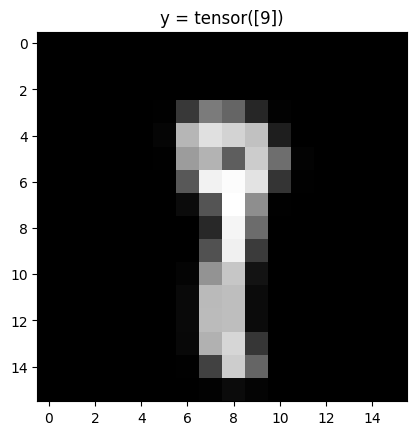

yhat:  tensor([1])


In [31]:
# Plot the mis-classified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  


<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a/">Mavis Zhou</a>


Thanks to Magnus <a href="http://www.hvass-labs.org/">Erik Hvass Pedersen</a> whose tutorials helped me understand convolutional Neural Network


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Srishti  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>
-->

## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
